100%|██████████| 6/6 [06:46<00:00, 67.79s/it] 


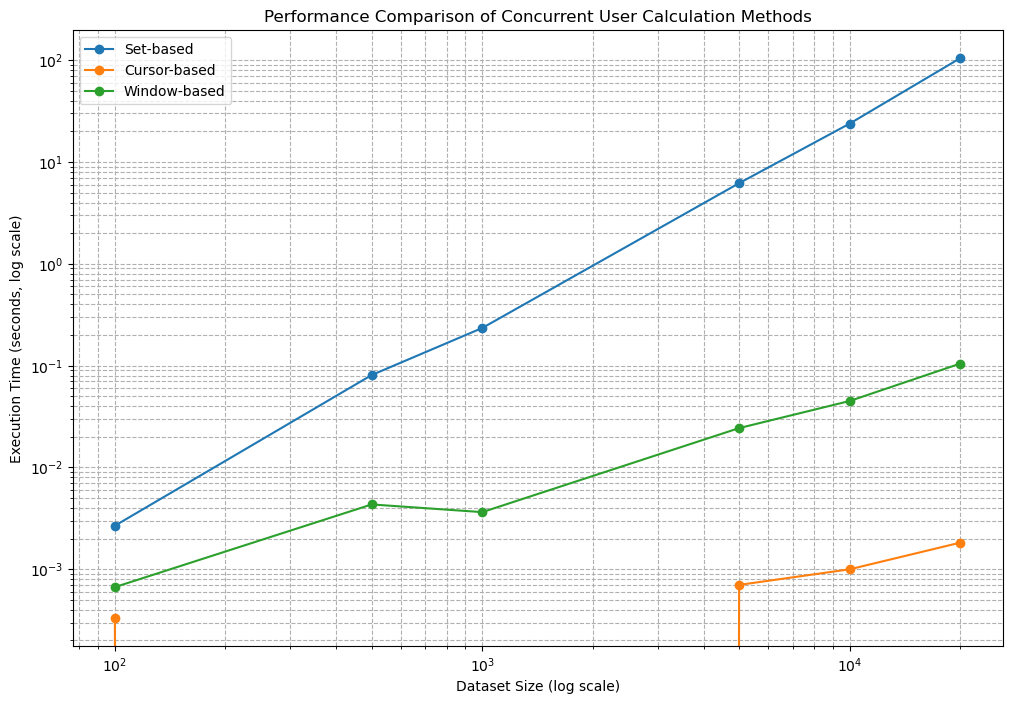

   Dataset Size  Set-based (s)  Cursor-based (s)  Window-based (s)
0           100       0.002678          0.000331          0.000668
1           500       0.080875          0.000000          0.004333
2          1000       0.234507          0.000000          0.003642
3          5000       6.196072          0.000702          0.024360
4         10000      23.853755          0.001000          0.044980
5         20000     104.804647          0.001827          0.104817


In [6]:
import sqlite3
import time
import matplotlib.pyplot as plt
from faker import Faker
import numpy as np
import pandas as pd
from tqdm import tqdm

# 初始化Faker生成测试数据
fake = Faker()
np.random.seed(42)

def generate_data(num_records):
    """生成测试数据集"""
    conn = sqlite3.connect(':memory:')
    cursor = conn.cursor()
    
    # 创建会话表
    cursor.execute('''
        CREATE TABLE sessions(
            id INTEGER PRIMARY KEY,
            start_time INTEGER,
            end_time INTEGER
        )
    ''')
    
    # 生成随机会话数据（使用时间戳）
    data = []
    base_time = int(time.time()) - 365*24*3600  # 一年前为基准
    
    for i in range(num_records):
        start = base_time + np.random.randint(0, 365*24*3600)
        duration = np.random.randint(60, 24*3600)  # 会话持续1分钟到1天
        end = start + duration
        data.append((start, end))
    
    # 批量插入数据
    cursor.executemany('INSERT INTO sessions(start_time, end_time) VALUES (?, ?)', data)
    conn.commit()
    return conn

def set_based(conn):
    """基于集合的解决方案"""
    cursor = conn.cursor()
    query = '''
        SELECT MAX(concurrent_count)
        FROM (
            SELECT time, 
                (SELECT COUNT(*) 
                 FROM sessions 
                 WHERE start_time <= t.time AND end_time >= t.time) AS concurrent_count
            FROM (
                SELECT start_time AS time FROM sessions
                UNION
                SELECT end_time AS time FROM sessions
            ) t
        )
    '''
    start_time = time.time()
    cursor.execute(query)
    result = cursor.fetchone()[0]
    return time.time() - start_time, result

def cursor_based(conn):
    """基于游标的解决方案"""
    cursor = conn.cursor()
    
    # 获取所有事件点（开始+1，结束-1）
    cursor.execute('''
        SELECT start_time AS time, 1 AS type FROM sessions
        UNION ALL
        SELECT end_time, -1 FROM sessions
        ORDER BY time, type DESC
    ''')
    
    events = cursor.fetchall()
    current_count = 0
    max_count = 0
    
    start_time = time.time()
    for event in events:
        current_count += event[1]
        if current_count > max_count:
            max_count = current_count
    return time.time() - start_time, max_count

def window_based(conn):
    """基于窗口函数的解决方案"""
    cursor = conn.cursor()
    query = '''
        SELECT MAX(concurrent_count) 
        FROM (
            SELECT SUM(type) OVER (ORDER BY time, type DESC) AS concurrent_count
            FROM (
                SELECT start_time AS time, 1 AS type FROM sessions
                UNION ALL
                SELECT end_time, -1 FROM sessions
            )
        )
    '''
    start_time = time.time()
    cursor.execute(query)
    result = cursor.fetchone()[0]
    return time.time() - start_time, result

def analyze_performance():
    """性能比较分析"""
    sizes = [100, 500, 1000, 5000, 10000, 20000]
    results = {'Set-based': [], 'Cursor-based': [], 'Window-based': []}
    
    for size in tqdm(sizes):
        conn = generate_data(size)
        
        # 每种方法运行3次取平均时间
        set_times = []
        cursor_times = []
        window_times = []
        
        for _ in range(3):
            t1, _ = set_based(conn)
            t2, _ = cursor_based(conn)
            t3, _ = window_based(conn)
            set_times.append(t1)
            cursor_times.append(t2)
            window_times.append(t3)
        
        results['Set-based'].append(np.mean(set_times))
        results['Cursor-based'].append(np.mean(cursor_times))
        results['Window-based'].append(np.mean(window_times))
        conn.close()
    
    # 绘制性能比较图
    plt.figure(figsize=(12, 8))
    for method in results:
        plt.plot(sizes, results[method], 'o-', label=method)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Dataset Size (log scale)')
    plt.ylabel('Execution Time (seconds, log scale)')
    plt.title('Performance Comparison of Concurrent User Calculation Methods')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.savefig('performance_comparison.png')
    plt.show()
    
    # 生成报告
    report = pd.DataFrame({
        'Dataset Size': sizes,
        'Set-based (s)': results['Set-based'],
        'Cursor-based (s)': results['Cursor-based'],
        'Window-based (s)': results['Window-based']
    })
    report.to_csv('performance_report.csv', index=False)
    print(report)

if __name__ == "__main__":
    analyze_performance()